In [2]:
import os
import pandas as pd

DATASET_PATH = "MVSA_Single"
LABEL_FILE = os.path.join(DATASET_PATH, "label.txt")
DATA_FOLDER = os.path.join(DATASET_PATH, "data")


labels = []
with open(LABEL_FILE, "r", encoding="utf-8") as file:
    next(file)  
    for line in file:
        parts = line.strip().split("\t")
        if len(parts) == 2:
            file_id, sentiment = parts
            text_label, image_label = sentiment.split(",")
            labels.append((file_id, text_label.strip(), image_label.strip()))

df = pd.DataFrame(labels, columns=["ID", "Text_Label", "Image_Label"])

print(df.head())

  ID Text_Label Image_Label
0  1    neutral    positive
1  2    neutral    positive
2  3    neutral    positive
3  4   positive    positive
4  5   positive    positive


Sample ID: 1
Text: How I feel today #legday #jelly #aching #gym
Text Sentiment: neutral, Image Sentiment: positive


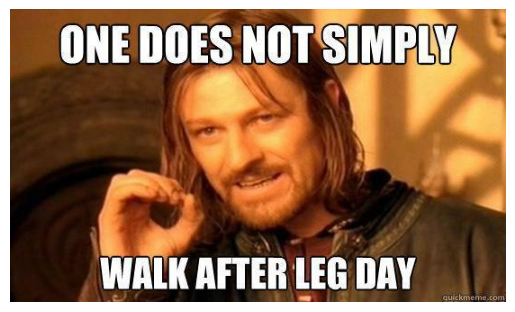

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

def load_text(file_id):
    text_file_path = os.path.join(DATA_FOLDER, f"{file_id}.txt")
    if os.path.exists(text_file_path):
        try:
            with open(text_file_path, "r", encoding="utf-8", errors="ignore") as file:
                return file.read().strip()
        except Exception as e:
            print(f"Error reading {text_file_path}: {e}")
            return ""  
    else:
        print(f"Warning: Missing file {text_file_path}")
        return ""
        
def show_image(file_id):
    image_file_path = os.path.join(DATA_FOLDER, f"{file_id}.jpg")  # Assuming images are .jpg
    image = Image.open(image_file_path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

sample_id = df.iloc[0]["ID"]

print(f"Sample ID: {sample_id}")
print(f"Text: {load_text(sample_id)}")
print(f"Text Sentiment: {df.iloc[0]['Text_Label']}, Image Sentiment: {df.iloc[0]['Image_Label']}")
show_image(sample_id)


In [4]:
import os

missing_files = []
for file_id in df["ID"]:
    text_file_path = os.path.join(DATA_FOLDER, f"{file_id}.txt")
    if not os.path.exists(text_file_path):
        missing_files.append(text_file_path)

if missing_files:
    print(f"Missing {len(missing_files)} text files:")
    print(missing_files[:5])  
else:
    print("All text files are present!")


All text files are present!


In [5]:
!pip install nltk
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'\W', ' ', text) 
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [word for word in words if word not in stop_words] 
    return " ".join(words)

df["Processed_Text"] = df["ID"].apply(lambda x: preprocess_text(load_text(x)))

vectorizer = TfidfVectorizer(max_features=5000)  
text_features = vectorizer.fit_transform(df["Processed_Text"])

print("Text Features Shape:", text_features.shape)

[nltk_data] Downloading package stopwords to C:\Users\SARTHAK
[nltk_data]     KHANDELWAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text Features Shape: (4869, 5000)


In [6]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMAGE_SIZE = (224, 224)  

def preprocess_image(file_id):
    image_file_path = os.path.join(DATA_FOLDER, f"{file_id}.jpg")  
    image = load_img(image_file_path, target_size=IMAGE_SIZE)  
    image_array = img_to_array(image) / 255.0  
    return image_array

image_features = np.array([preprocess_image(file_id) for file_id in df["ID"]])

print("Image Features Shape:", image_features.shape)

Image Features Shape: (4869, 224, 224, 3)


In [7]:
from sklearn.model_selection import train_test_split

text_features_array = text_features.toarray()  
image_features_array = np.array(image_features)

X_text_train, X_text_temp, X_image_train, X_image_temp, y_train, y_temp = train_test_split(
    text_features_array, image_features_array, df["Text_Label"], test_size=0.2, random_state=42
)

X_text_val, X_text_test, X_image_val, X_image_test, y_val, y_test = train_test_split(
    X_text_temp, X_image_temp, y_temp, test_size=0.5, random_state=42
)

print("Train Text Shape:", X_text_train.shape)
print("Train Image Shape:", X_image_train.shape)
print("Validation Text Shape:", X_text_val.shape)
print("Validation Image Shape:", X_image_val.shape)
print("Test Text Shape:", X_text_test.shape)
print("Test Image Shape:", X_image_test.shape)

Train Text Shape: (3895, 5000)
Train Image Shape: (3895, 224, 224, 3)
Validation Text Shape: (487, 5000)
Validation Image Shape: (487, 224, 224, 3)
Test Text Shape: (487, 5000)
Test Image Shape: (487, 224, 224, 3)


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Concatenate

TEXT_FEATURES_SHAPE = 5000
IMAGE_INPUT_SHAPE = (224, 224, 3)

text_input = Input(shape=(TEXT_FEATURES_SHAPE,), name="text_input")
image_input = Input(shape=IMAGE_INPUT_SHAPE, name="image_input")

text_dense = Dense(512, activation="relu")(text_input)
text_dense = Dropout(0.3)(text_dense)
text_features = Dense(256, activation="relu")(text_dense)

base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=image_input)
base_model.trainable = False  
image_output = GlobalAveragePooling2D()(base_model.output)
image_features = Dense(256, activation="relu")(image_output)

text_gate = Dense(256, activation="sigmoid", name="text_gate")(text_features)
image_gate = Dense(256, activation="sigmoid", name="image_gate")(image_features)

gated_text = Multiply()([text_features, text_gate])
gated_image = Multiply()([image_features, image_gate])

fused_features = Concatenate()([gated_text, gated_image])
fusion_dense = Dense(128, activation="relu")(fused_features)

fusion_dense = Dropout(0.3)(fusion_dense)
output = Dense(3, activation="softmax", name="output")(fusion_dense)

model = Model(inputs=[text_input, image_input], outputs=output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

C:\Users\SARTHAK KHANDELWAL\AppData\Local\Temp\ipykernel_5732\2853363821.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=image_input)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 5,475,395 (20.89 MB)

 Trainable params: 3,217,411 (12.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5", monitor="val_loss", save_best_only=True, verbose=1
)
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True, verbose=1
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=5, verbose=1
)

history = model.fit(
    [X_text_train, X_image_train], y_train_encoded,
    validation_data=([X_text_val, X_image_val], y_val_encoded),
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb]
)

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.4007 - loss: 1.0892
Epoch 1: val_loss improved from inf to 0.90169, saving model to best_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 101s 599ms/step - accuracy: 0.4012 - loss: 1.0887 - val_accuracy: 0.5996 - val_loss: 0.9017 - learning_rate: 0.0010
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7520 - loss: 0.6114
Epoch 2: val_loss improved from 0.90169 to 0.84659, saving model to best_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 59s 481ms/step - accuracy: 0.7521 - loss: 0.6113 - val_accuracy: 0.6181 - val_loss: 0.8466 - learning_rate: 0.0010
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9238 - loss: 0.2369
Epoch 3: val_loss did not improve from 0.84659
122/122 ━━━━━━━━━━━━━━━━━━━━ 59s 480ms/step - accuracy: 0.9238 - loss: 0.2370 - val_accuracy: 0.6140 - val_loss: 1.1971 - learning_rate: 0.0010
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9705 - loss: 0.1004
Epoch 4: val_loss did not improve from 0.84659
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 473ms/step - accuracy: 0.9705 - loss: 0.1005 - val_accuracy: 0.6016 - val_loss: 1.3497 - learning_rate: 0.0010
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9806 - loss: 0.0655
Epoch 5: val_loss did not improve from 0.84659
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 477ms/step - accuracy: 0.9806 - loss: 0.0655 - val_accuracy: 0.6057 - val_loss: 1.4698 - learning_rate: 0.0010
Epoch 6/20
122/122 

In [10]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

with open("tfidf_vectorizer3.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
VOCAB_SIZE = 10000
text_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
text_tokenizer.fit_on_texts(df["Processed_Text"])
with open("text_tokenizer3.pkl", "wb") as f:
    pickle.dump(text_tokenizer, f)

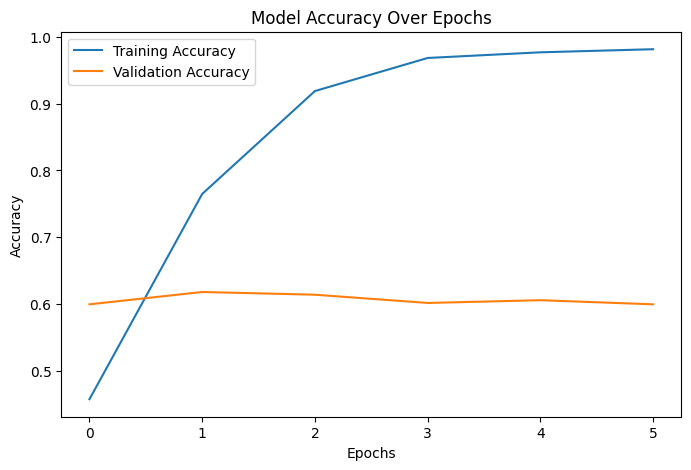

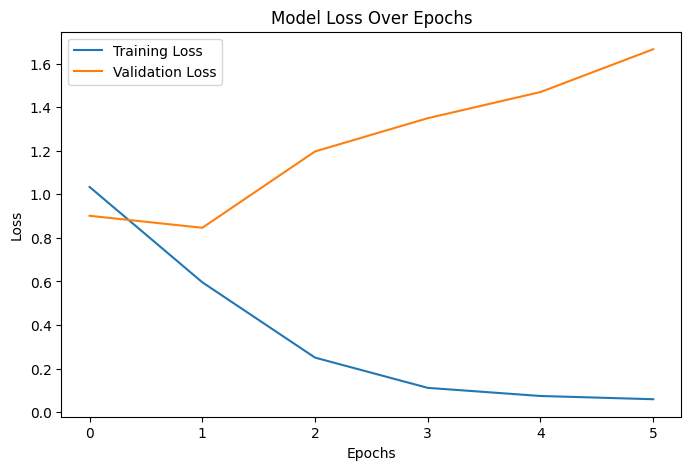

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import classification_report, accuracy_score

y_test_encoded = label_encoder.transform(y_test)
test_loss, test_accuracy = model.evaluate([X_text_test, X_image_test], y_test_encoded, verbose=1)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred_probs = model.predict([X_text_test, X_image_test])
y_pred = y_pred_probs.argmax(axis=1)

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 0.6659 - loss: 0.7800
Test Accuracy: 0.6632
Test Loss: 0.7941
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 439ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.58      0.61       118
     neutral       0.65      0.68      0.67       187
    positive       0.69      0.69      0.69       182

    accuracy                           0.66       487
   macro avg       0.66      0.65      0.66       487
weighted avg       0.66      0.66      0.66       487



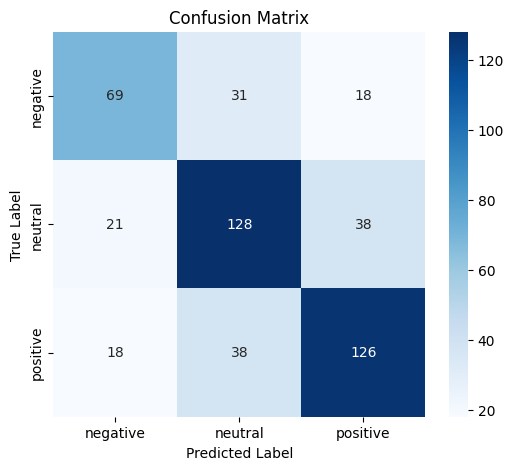

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()